# Estimating single-sample co-expression networks for yeast genetic screens using BONOBO
Enakshi Saha <sup>1</sup> and Viola Fanfani  <sup>1</sup>

<sup>1</sup> Harvard T.H. Chan School of Public Health, Boston, MA, USA.

# Introduction
BONOBO (Bayesian Optimized Networks Obtained By assimilating Omics data) [1] is an empirical Bayesian model that derives
individual sample-specific co-expression networks, facilitating the discovery of differentially co-regulated gene pairs
between different conditions and/or phenotypes. BONOBO derives positive semidefinite co-expression networks from input
data alone, without using any external reference datasets.

Below is the general illustration on how BONOBO works:

![Graphical-Abstract](https://netzoo.s3.us-east-2.amazonaws.com/netbooks/bonobo/bonobo-graphical.png)


BONOBO requires a gene expression matrix as input, from which we would like to extract sample-specific correlation
networks. Then, for each of the samples, BONOBO infers the network by using both the Pearson's correlation matrix
computed on $N-1$ samples and the sample-specific squared-deviation about the mean. BONOBO outputs $N$ co-expression
networks, one for each sample, and the associated p-values for each of the gene-gene estimated edges.


In the rest of this notebook we will show an example on how to compute BONOBO networks using the
[netZooPy](https://github.com/netZoo/netZooPy) package [3].

We recommend to install the netZooPy package through conda (`conda install -c conda-forge -c anaconda -c netzoo
netzoopy`) and to double check that the `pytables` installation is working properly. 
 

# Importing packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import glob as glob
import os
from netZooPy.bonobo.bonobo import Bonobo # To import Bonobo

Next, we define data path on Netbooks' server.

In [ ]:
ppath = '/opt/data/netZooPy/bonobo/'

# 1. Compute BONOBO networks

To compute BONOBO networks we need a tab separated expression file, with samples on the columns and genes on the rows.

In this case we have generated the file from Jackson and colleagues' [2]
raw data ([GEO:SE125162](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE125162))  following these steps:

Creating pseudobulk from raw counts: 
- group by Genotype and condition and averaging counts by gene. (132 genotype x condition, 6529 non-zero genes)
- Remove genes there are always zero (GSE125162_all_pseudobulk_counts.txt)
- df_nonzero_log = np.log(1+df_nonzero) (GSE125162_all_pseudobulk_logcounts.txt)

The data is composed of 132 samples and 6520 genes. There are no samples that have all genes non-expressed.

## 1.1. Check the data and generate output folder

First we need to specify which data we need and where the results are going to be saved. 

In [2]:
yeast_fn = ppath+'pseudobulk_nonzero_logcounts.tsv'

The, we specify the output folder.

In [ ]:
output_folder = '../results/bonobo_netbook/'

If the folder doesn't exist, we create it.

In [3]:
if os.path.exists(output_folder) == False:
    os.makedirs(output_folder)
    print('Created output folder:%s' %output_folder)
else:
    print('Output folder exists:%s' %output_folder)

Output folder exists:../results/bonobo_netbook/


In [4]:
all_samples = pd.read_csv(yeast_fn, nrows = 3, sep = '\t', index_col=0).columns.tolist()

['WT(ho)_AmmoniumSulfate', 'WT(ho)_CStarve', 'WT(ho)_Glutamine', 'WT(ho)_MinimalEtOH', 'WT(ho)_MinimalGlucose', 'WT(ho)_Proline', 'WT(ho)_Urea', 'WT(ho)_YPD', 'WT(ho)_YPDDiauxic', 'WT(ho)_YPDRapa', 'WT(ho)_YPEtOH', 'dal80_AmmoniumSulfate', 'dal80_CStarve', 'dal80_Glutamine', 'dal80_MinimalEtOH', 'dal80_MinimalGlucose', 'dal80_Proline', 'dal80_Urea', 'dal80_YPD', 'dal80_YPDDiauxic', 'dal80_YPDRapa', 'dal80_YPEtOH', 'dal81_AmmoniumSulfate', 'dal81_CStarve', 'dal81_Glutamine', 'dal81_MinimalEtOH', 'dal81_MinimalGlucose', 'dal81_Proline', 'dal81_Urea', 'dal81_YPD', 'dal81_YPDDiauxic', 'dal81_YPDRapa', 'dal81_YPEtOH', 'dal82_AmmoniumSulfate', 'dal82_CStarve', 'dal82_Glutamine', 'dal82_MinimalEtOH', 'dal82_MinimalGlucose', 'dal82_Proline', 'dal82_Urea', 'dal82_YPD', 'dal82_YPDDiauxic', 'dal82_YPDRapa', 'dal82_YPEtOH', 'gat1_AmmoniumSulfate', 'gat1_CStarve', 'gat1_Glutamine', 'gat1_MinimalEtOH', 'gat1_MinimalGlucose', 'gat1_Proline', 'gat1_Urea', 'gat1_YPD', 'gat1_YPDDiauxic', 'gat1_YPDRapa',

With the following command you can check which samples have already been computed and which samples are left to be computed, which is not our case here.

In [ ]:
left_uncomputed=0

In [ ]:
if left_uncomputed==1:
    done_bonobo = [i.split('/')[-1][7:-3] for i in  glob.glob(output_folder + 'bonobo/bonobo*.h5')]
    left = list(set(all_samples) - set(done_bonobo))

In [ ]:
print(all_samples)

You can see that the samples are named with the <genotype>\_<medium> convention. 

For simplicity, we select a limited amount of samples, such that we don't have to wait too much time to compute all
networks.

In [5]:
all_samples

['WT(ho)_AmmoniumSulfate',
 'WT(ho)_CStarve',
 'WT(ho)_Glutamine',
 'WT(ho)_MinimalEtOH',
 'WT(ho)_MinimalGlucose',
 'WT(ho)_Proline',
 'WT(ho)_Urea',
 'WT(ho)_YPD',
 'WT(ho)_YPDDiauxic',
 'WT(ho)_YPDRapa',
 'WT(ho)_YPEtOH',
 'dal80_AmmoniumSulfate',
 'dal80_CStarve',
 'dal80_Glutamine',
 'dal80_MinimalEtOH',
 'dal80_MinimalGlucose',
 'dal80_Proline',
 'dal80_Urea',
 'dal80_YPD',
 'dal80_YPDDiauxic',
 'dal80_YPDRapa',
 'dal80_YPEtOH',
 'dal81_AmmoniumSulfate',
 'dal81_CStarve',
 'dal81_Glutamine',
 'dal81_MinimalEtOH',
 'dal81_MinimalGlucose',
 'dal81_Proline',
 'dal81_Urea',
 'dal81_YPD',
 'dal81_YPDDiauxic',
 'dal81_YPDRapa',
 'dal81_YPEtOH',
 'dal82_AmmoniumSulfate',
 'dal82_CStarve',
 'dal82_Glutamine',
 'dal82_MinimalEtOH',
 'dal82_MinimalGlucose',
 'dal82_Proline',
 'dal82_Urea',
 'dal82_YPD',
 'dal82_YPDDiauxic',
 'dal82_YPDRapa',
 'dal82_YPEtOH',
 'gat1_AmmoniumSulfate',
 'gat1_CStarve',
 'gat1_Glutamine',
 'gat1_MinimalEtOH',
 'gat1_MinimalGlucose',
 'gat1_Proline',
 'gat1_Ure

In [6]:
my_samples = [i for i in all_samples  if (not (i.startswith('dal80') or i.startswith('dal81') or i.startswith('dal82') or i.startswith('gat1')) and (i.endswith('YPDRapa') or i.endswith('CStarve') or i.endswith('MinimalGlucose') )) ]

In [7]:
len(my_samples)

24

We have selected 24 samples, arbitrarily, coming from 3 different conditions: YPD Rapa, CStarve and Minimal Glucose. We will use these samples to compute the Bonobo network.

## 1.2. Computing BONOBO networks

BONOBO can be simply computed by first instantiating the Bonobo class, and then calling the `run_bonobo` method.

Below is the example on how these networks have been generated. We first initialize the Bonobo object.

In [9]:
bonobo_obj_sparse = Bonobo(yeast_fn)
# If you want to run bonobo with a subset of the data, you can specify the sample names and pass them to the run_bonobo
# method. In this case we are using all samples
#sample_names=['WT(ho)_AmmoniumSulfate','WT(ho)_CStarve','WT(ho)_Glutamine']
#sample_names = left


BONOBO: preparing expression
Reading expression data...
None
  Elapsed time: 0.10 sec.
BONOBO: We are starting to compute the bonobos...
BONOBO: bonobo for sample gln3_CStarve
BONOBO: computing bonobo for sample gln3_CStarve
keep Bonobo whole, and use pvals to threshold and sparsify
Saving BONOBO for sample gln3_CStarve
Saving pvalues for sample gln3_CStarve
BONOBO: bonobo for sample gzf3_YPDRapa
BONOBO: computing bonobo for sample gzf3_YPDRapa
keep Bonobo whole, and use pvals to threshold and sparsify
Saving BONOBO for sample gzf3_YPDRapa
Saving pvalues for sample gzf3_YPDRapa
BONOBO: bonobo for sample stp1_CStarve
BONOBO: computing bonobo for sample stp1_CStarve
keep Bonobo whole, and use pvals to threshold and sparsify
Saving BONOBO for sample stp1_CStarve
Saving pvalues for sample stp1_CStarve
BONOBO: bonobo for sample stp1_YPDRapa
BONOBO: computing bonobo for sample stp1_YPDRapa
keep Bonobo whole, and use pvals to threshold and sparsify
Saving BONOBO for sample stp1_YPDRapa
Saving

Now, we run the actual bonobo computation, with the following parameters.
We cannot keep all the data in memory in this case, these networks are too large: `keep_in_memory=False`
We will save the p-values for the edges in the output_folder: `sparsify=True, save_pvals=True`
The output format is hd5, which is the most efficient way to store the data on disk: `output_fmt='.h5'`

In [ ]:
bonobo_obj_sparse.run_bonobo(keep_in_memory=False, output_fmt='.h5', sparsify=True, output_folder=output_folder+'bonobo/', save_pvals=True, sample_names=my_samples)

It took 2 minutes to generate the networks and you can see which files have been generated 

In [13]:
nets_fn = glob.glob(output_folder+'bonobo/bonobo*.h5')
pvals_prefix = (output_folder+'bonobo/pvals_')

len(nets_fn), nets_fn[:5]

(24,
 ['../results/bonobo_netbook/bonobo/bonobo_stp1_YPDRapa.h5',
  '../results/bonobo_netbook/bonobo/bonobo_WT(ho)_YPDRapa.h5',
  '../results/bonobo_netbook/bonobo/bonobo_stp2_MinimalGlucose.h5',
  '../results/bonobo_netbook/bonobo/bonobo_rtg3_MinimalGlucose.h5',
  '../results/bonobo_netbook/bonobo/bonobo_rtg3_CStarve.h5'])

## 1.3. Inspecting BONOBO networks

Here is what BONOBOs look like, and how to use the pvalues to threshold them.

In [19]:
test_bonobo = pd.read_hdf(nets_fn[0])
test_bonobo.head()

,YDL248W,YDL247W,YDL246C,YDL245C,YDL244W,YDL243C,YDL242W,YDL241W,YDL240W,YDL239C,...,Q0130,Q0140,X21S_rRNA,Q0160,Q0250,Q0255,Q0275,RPM1,KANMX,NATMX
0,1.000000,-0.004713,-0.027151,-0.065583,0.161053,0.023919,0.081492,0.049051,0.121486,-0.028730,...,0.082720,-0.030662,0.073071,-0.043745,0.095154,-0.115001,-0.051945,-0.055754,0.050119,-0.000713
1,-0.004713,1.000000,-0.015998,0.005976,0.013819,0.098602,-0.023721,-0.004827,-0.037035,0.186171,...,0.167198,-0.017630,0.129244,0.145966,0.144275,0.173603,0.123153,0.715417,-0.064908,-0.021474
2,-0.027151,-0.015998,1.000000,0.006558,0.051620,0.036151,0.191271,0.099669,0.029251,0.098184,...,-0.087037,-0.025754,-0.073203,-0.052246,-0.014440,0.285625,0.109476,-0.023432,0.050170,0.097030
3,-0.065583,0.005976,0.006558,1.000000,0.116636,0.318489,0.038376,0.004880,0.240116,0.120043,...,0.024142,-0.030346,0.020963,-0.064106,-0.039096,-0.039753,-0.053980,-0.027610,-0.005682,0.018722
4,0.161053,0.013819,0.051620,0.116636,1.000000,0.458843,0.172490,0.195292,0.194193,0.370324,...,0.464935,0.098130,0.480069,0.290717,0.010426,0.082925,0.146936,-0.028859,0.024253,0.026033


Rows have the same name as columns in the bonobo network.
We can actually check that they are symmetric (use np close to avoid rounding issues with floating numbers)

In [32]:
assert(np.isclose(test_bonobo.values, test_bonobo.values.T).all())
test_bonobo.index = test_bonobo.columns
test_bonobo.iloc[:5,:5]

,YDL248W,YDL247W,YDL246C,YDL245C,YDL244W
YDL248W,1.000000,-0.004713,-0.027151,-0.065583,0.161053
YDL247W,-0.004713,1.000000,-0.015998,0.005976,0.013819
YDL246C,-0.027151,-0.015998,1.000000,0.006558,0.051620
YDL245C,-0.065583,0.005976,0.006558,1.000000,0.116636
YDL244W,0.161053,0.013819,0.051620,0.116636,1.000000


We now check BONOBO's network edge distribution.

<Axes: ylabel='Count'>

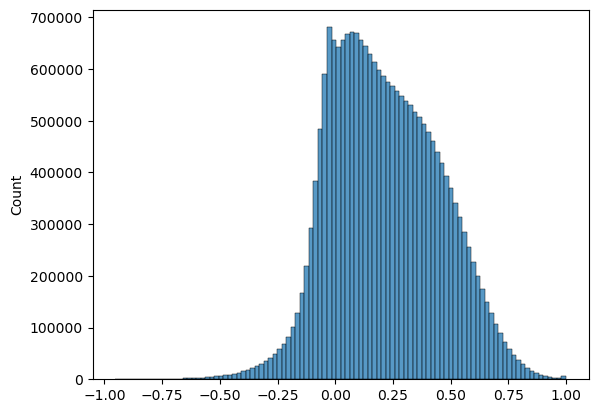

In [42]:
sns.histplot(test_bonobo.values[np.tril(np.ones(test_bonobo.shape))==1].flatten(), bins=100)

We do the same for the p-values. We first check if dimensions are correct.

In [34]:
test_pvals = pd.read_hdf(pvals_prefix + nets_fn[0].split('/')[-1][7:])
test_pvals.head()

,YDL248W,YDL247W,YDL246C,YDL245C,YDL244W,YDL243C,YDL242W,YDL241W,YDL240W,YDL239C,...,Q0130,Q0140,X21S_rRNA,Q0160,Q0250,Q0255,Q0275,RPM1,KANMX,NATMX
0,0.003696,0.984157,0.908969,0.782823,0.503513,0.919759,0.732302,0.836499,0.611677,0.903705,...,0.728455,0.897271,0.758893,0.853937,0.689979,0.630527,0.827029,0.814609,0.833001,0.997604
1,0.984157,0.003696,0.946273,0.979914,0.953580,0.679472,0.920420,0.983774,0.876107,0.441473,...,0.487840,0.940804,0.589521,0.543305,0.547880,0.471846,0.606878,0.016022,0.784996,0.927933
2,0.908969,0.946273,0.003696,0.977959,0.828091,0.879037,0.429538,0.676233,0.901969,0.680740,...,0.714998,0.913630,0.758471,0.826045,0.951498,0.249141,0.646818,0.921388,0.832835,0.684252
3,0.782823,0.979914,0.977959,0.003696,0.625748,0.203270,0.871666,0.983599,0.326694,0.615847,...,0.919015,0.898322,0.929644,0.787574,0.869284,0.867111,0.820388,0.907440,0.980903,0.937146
4,0.503513,0.953580,0.828091,0.625748,0.003696,0.081692,0.474601,0.420286,0.422801,0.146009,...,0.078470,0.680904,0.071009,0.241501,0.964969,0.727814,0.540693,0.903274,0.918644,0.912702


In [35]:
assert(np.isclose(test_pvals.values, test_pvals.values.T).all())
test_pvals.index = test_pvals.columns
test_pvals.iloc[:5,:5]

,YDL248W,YDL247W,YDL246C,YDL245C,YDL244W
YDL248W,0.003696,0.984157,0.908969,0.782823,0.503513
YDL247W,0.984157,0.003696,0.946273,0.979914,0.953580
YDL246C,0.908969,0.946273,0.003696,0.977959,0.828091
YDL245C,0.782823,0.979914,0.977959,0.003696,0.625748
YDL244W,0.503513,0.953580,0.828091,0.625748,0.003696


Then, we check the p-values' distribution.

<Axes: ylabel='Count'>

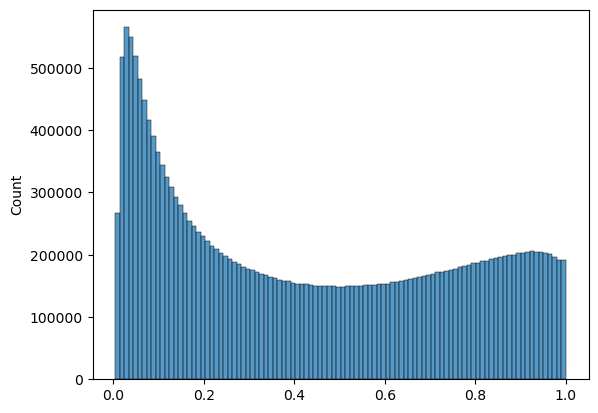

In [41]:
sns.histplot(test_pvals.values[np.tril(np.ones(test_pvals.shape))==1].flatten(), bins=100)

In [44]:
test_bonobo[test_pvals<0.05]

,YDL248W,YDL247W,YDL246C,YDL245C,YDL244W,YDL243C,YDL242W,YDL241W,YDL240W,YDL239C,...,Q0130,Q0140,X21S_rRNA,Q0160,Q0250,Q0255,Q0275,RPM1,KANMX,NATMX
YDL248W,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YDL247W,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.715417,NaN,NaN
YDL246C,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YDL245C,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YDL244W,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q0255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Q0275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
RPM1,NaN,0.715417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
KANMX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.677262


We now filter BONOBO networks for only those with significant edges.

<Axes: ylabel='Count'>

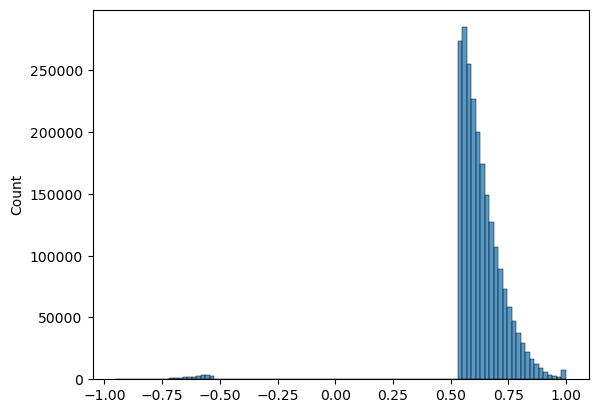

In [46]:
sns.histplot((test_bonobo[test_pvals<0.05].values[np.tril(np.ones(test_pvals.shape))==1]).flatten(), bins = 100)

# 2. Get the BONOBO networks for the analysis

Here we define two functions to read BONOBO networks sequentially and generate a manageable dataframe we can use to analyze the data. BONOBO networks are dense symmetric correlation matrices of size `NxN`. Using all the edges for downstream analysis is unfeasible or computationally expensive, hence we focus on three strategies (sparse, random, gene)to reduce the amount of data that is used. Also, Empirical data suggests biological networks are sparse. Therefore, BONOBO allows to threshold the edges using p-values (sparse networks), alternatively one could randomly select K edges from all networks (random). Finally, we can select all edges involving a specific node (gene), for instance all edges that involve GCN4 subnetwork.

In [47]:
def get_bonobo_dataframe(nets_fn, pvals_prefix = None, strategy = 'sparse', pth = 0.05, nk=1000, gene = 'YEL009C'):

    df_bonobos = pd.DataFrame()

    for iii,bbb in enumerate(nets_fn):
        if iii>-1:
            k = bbb.split('/')[-1][:-3][7:]
            temp = pd.read_hdf(bbb)
                
            temp.index = temp.columns
            # Upper triangular matrix
            temp = temp.where(np.triu(np.ones(temp.shape), k = 1).astype(bool))
            # Put in long format
            temp = temp.stack().reset_index() 
            # Rename columns
            temp.columns = ['gene1','gene2',k]
            
            if strategy == 'sparse':
                
                print(pvals_prefix + k + '.h5')
                assert os.path.isfile(pvals_prefix + k + '.h5'), 'pvals file not found'
                pvals_fn = pvals_prefix + k + '.h5'
                pvals = pd.read_hdf(pvals_fn)
                pvals = pvals.where(np.triu(np.ones(pvals.shape), k = 1).astype(bool))
                pvals = pvals.stack().reset_index() 
                
                ps = pvals.iloc[:,2].values
                
                temp = temp[ps<pth]

                if iii== 0:
                    df_bonobos = temp
                else:
                    df_bonobos = pd.merge(df_bonobos, temp, how = 'outer', on = ['gene1','gene2'])
                    
            elif strategy == 'random':
                if iii==0:
                    print(k)
                    print(nk)
                    index_random = np.random.choice(np.arange(len(temp.index)), nk, replace = False)
                    df_bonobos = temp.iloc[index_random,:]
                    
                else:
                    #df_bonobos[k] = temp.iloc[index_random,:][k]
                    df_bonobos = pd.concat([df_bonobos, temp.iloc[index_random,:][k]], axis = 1)
                    
            elif strategy == 'gene':
                # Get only one gene
                if iii == 0:
                    df_bonobos = temp[(temp['gene1'] == gene) | (temp['gene2'] == gene)]
                else:
                    df_bonobos = pd.concat([df_bonobos, temp[(temp['gene1'] == gene) | (temp['gene2'] == gene)][k]], axis = 1)
                    
            else:
                if iii == 0:
                    df_bonobos = temp
                else:
                    #df_bonobos[k] = temp[k]
                    df_bonobos = pd.concat([df_bonobos, temp[k]], axis = 1)
            

    return(df_bonobos)

The second function fetches edges conected to a given gene from the Bonobo network.

In [48]:
def get_gene_bonobo_dataframe(nets_fn, gene = 'YEL009C'):

    df_bonobos = pd.DataFrame()

    for iii,bbb in enumerate(nets_fn):
        if iii>-1:
            k = bbb.split('/')[-1][:-3][7:]
            temp = pd.read_hdf(bbb)
                
            temp.index = temp.columns
            
            temp = temp.loc[:,[gene]]
        
            temp['gene1'] = temp.index
            temp['gene2'] = gene
            temp[k] = temp.loc[:,[gene]]
            temp = temp.loc[:,['gene1','gene2',k]]
            
            if iii == 0:
                df_bonobos = temp
            else:
                df_bonobos = pd.concat([df_bonobos, temp.loc[:,k]], axis = 1)

    return(df_bonobos)

## 2.1. Sparse startegy

Here you should change the paths depending on where you want to save the data.

In [49]:
nets_fn = glob.glob(output_folder+'bonobo/bonobo*.h5')
pvals_prefix = (output_folder+'bonobo/pvals_')

We use the sparse stargetgy based on p-values to obtain networks.

In [53]:
bonobo_sparse = get_bonobo_dataframe(nets_fn, pvals_prefix = pvals_prefix, strategy = 'sparse', pth=0.01)

../results/bonobo_netbook/bonobo/pvals_stp1_YPDRapa.h5
../results/bonobo_netbook/bonobo/pvals_WT(ho)_YPDRapa.h5
../results/bonobo_netbook/bonobo/pvals_stp2_MinimalGlucose.h5
../results/bonobo_netbook/bonobo/pvals_rtg3_MinimalGlucose.h5
../results/bonobo_netbook/bonobo/pvals_rtg3_CStarve.h5
../results/bonobo_netbook/bonobo/pvals_gzf3_MinimalGlucose.h5
../results/bonobo_netbook/bonobo/pvals_stp2_YPDRapa.h5
../results/bonobo_netbook/bonobo/pvals_stp2_CStarve.h5
../results/bonobo_netbook/bonobo/pvals_gzf3_YPDRapa.h5
../results/bonobo_netbook/bonobo/pvals_WT(ho)_MinimalGlucose.h5
../results/bonobo_netbook/bonobo/pvals_gcn4_YPDRapa.h5
../results/bonobo_netbook/bonobo/pvals_WT(ho)_CStarve.h5
../results/bonobo_netbook/bonobo/pvals_stp1_MinimalGlucose.h5
../results/bonobo_netbook/bonobo/pvals_gln3_MinimalGlucose.h5
../results/bonobo_netbook/bonobo/pvals_gzf3_CStarve.h5
../results/bonobo_netbook/bonobo/pvals_stp1_CStarve.h5
../results/bonobo_netbook/bonobo/pvals_gcn4_MinimalGlucose.h5
../results

We can also save the network (not needeed when running on the server).

In [ ]:
save_network=0

In [ ]:
if save_network == 1:
    bonobo_sparse.to_hdf(output_folder+'bonobo_sparse_001.h5', key='bonobo_sparse', mode='w')

In [64]:
bonobo_sparse

,gene1,gene2,stp1_YPDRapa,WT(ho)_YPDRapa,stp2_MinimalGlucose,rtg3_MinimalGlucose,rtg3_CStarve,gzf3_MinimalGlucose,stp2_YPDRapa,stp2_CStarve,...,gzf3_CStarve,stp1_CStarve,gcn4_MinimalGlucose,gln3_CStarve,rtg1_YPDRapa,gcn4_CStarve,rtg1_CStarve,rtg3_YPDRapa,gln3_YPDRapa,rtg1_MinimalGlucose
0,PWR1,YFL012W,0.921189,0.921189,0.921189,0.921189,0.921189,0.921189,0.921189,0.921189,...,0.921189,0.921188,0.921189,0.921189,0.921189,0.921189,0.921189,0.921189,0.921189,0.921189
1,Q0045,Q0050,0.861894,0.861966,0.848569,0.821176,0.862205,0.852883,0.861998,0.861981,...,0.862348,0.861553,0.855428,0.862023,0.862021,0.859745,0.861807,0.862441,0.860253,0.843846
2,Q0045,Q0130,0.891208,0.891409,0.885058,0.878817,0.891659,0.889589,0.891455,0.890913,...,0.891477,0.890795,0.890038,0.891184,0.891343,0.892194,0.891546,0.891404,0.891249,0.887918
3,Q0045,X21S_rRNA,0.871173,0.871121,0.865842,0.853161,0.871171,0.867259,0.871117,0.870364,...,0.871199,0.870472,0.850499,0.870936,0.871017,0.871442,0.871225,0.871274,0.871238,0.855712
4,Q0050,Q0075,0.801918,0.802006,NaN,NaN,0.801662,0.799036,0.801933,0.803603,...,0.801375,0.800160,NaN,0.802081,0.802212,0.801051,0.801952,0.802332,0.800470,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182157,snR74,YMR057C,0.855335,0.855335,0.855335,0.855335,0.855334,0.855335,0.855335,0.855334,...,0.855334,0.855334,0.855335,0.855334,0.855335,0.855334,0.855334,0.855335,0.855335,0.855335
182158,snR75,YNL171C,0.899564,0.899565,0.899564,0.899565,0.899564,0.899564,0.899565,0.899564,...,0.899564,0.899564,0.899564,0.899564,0.899565,0.899564,0.899564,0.899565,0.899565,0.899565
182159,snR79,YLR415C,0.945555,0.945555,0.945554,0.945555,0.945554,0.945554,0.945555,0.945554,...,0.945554,0.945554,0.945555,0.945554,0.945555,0.945554,0.945554,0.945555,0.945555,0.945555
182160,snR79,YNL284C.A,0.987528,0.921933,0.987528,0.987528,0.987528,0.987528,0.987528,0.987528,...,0.987528,0.987528,0.987528,0.987528,0.987528,0.987528,0.987528,0.987528,0.987528,0.987528


### 2.1.1. Correlation between BONOBO samples



First we need to generate an auxiliary table to keep track of the genotype and medium name.

In [71]:
bonobo_names_df = pd.DataFrame()
bonobo_names_df.index = bonobo_sparse.columns[2:]
bonobo_names_df['genotype'] = [i.split('_')[0] for i in bonobo_names_df.index]
bonobo_names_df['medium'] = [i.split('_')[1] for i in bonobo_names_df.index]
bonobo_names_df

,genotype,medium
stp1_YPDRapa,stp1,YPDRapa
WT(ho)_YPDRapa,WT(ho),YPDRapa
stp2_MinimalGlucose,stp2,MinimalGlucose
rtg3_MinimalGlucose,rtg3,MinimalGlucose
rtg3_CStarve,rtg3,CStarve
gzf3_MinimalGlucose,gzf3,MinimalGlucose
stp2_YPDRapa,stp2,YPDRapa
stp2_CStarve,stp2,CStarve
gzf3_YPDRapa,gzf3,YPDRapa
WT(ho)_MinimalGlucose,WT(ho),MinimalGlucose


In [72]:
corrs = bonobo_sparse.iloc[:,2:].corr()

/tmp/ipykernel_7945/721169331.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Set1', len(colors))
/tmp/ipykernel_7945/721169331.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = matplotlib.cm.get_cmap('plasma', len(colors2))


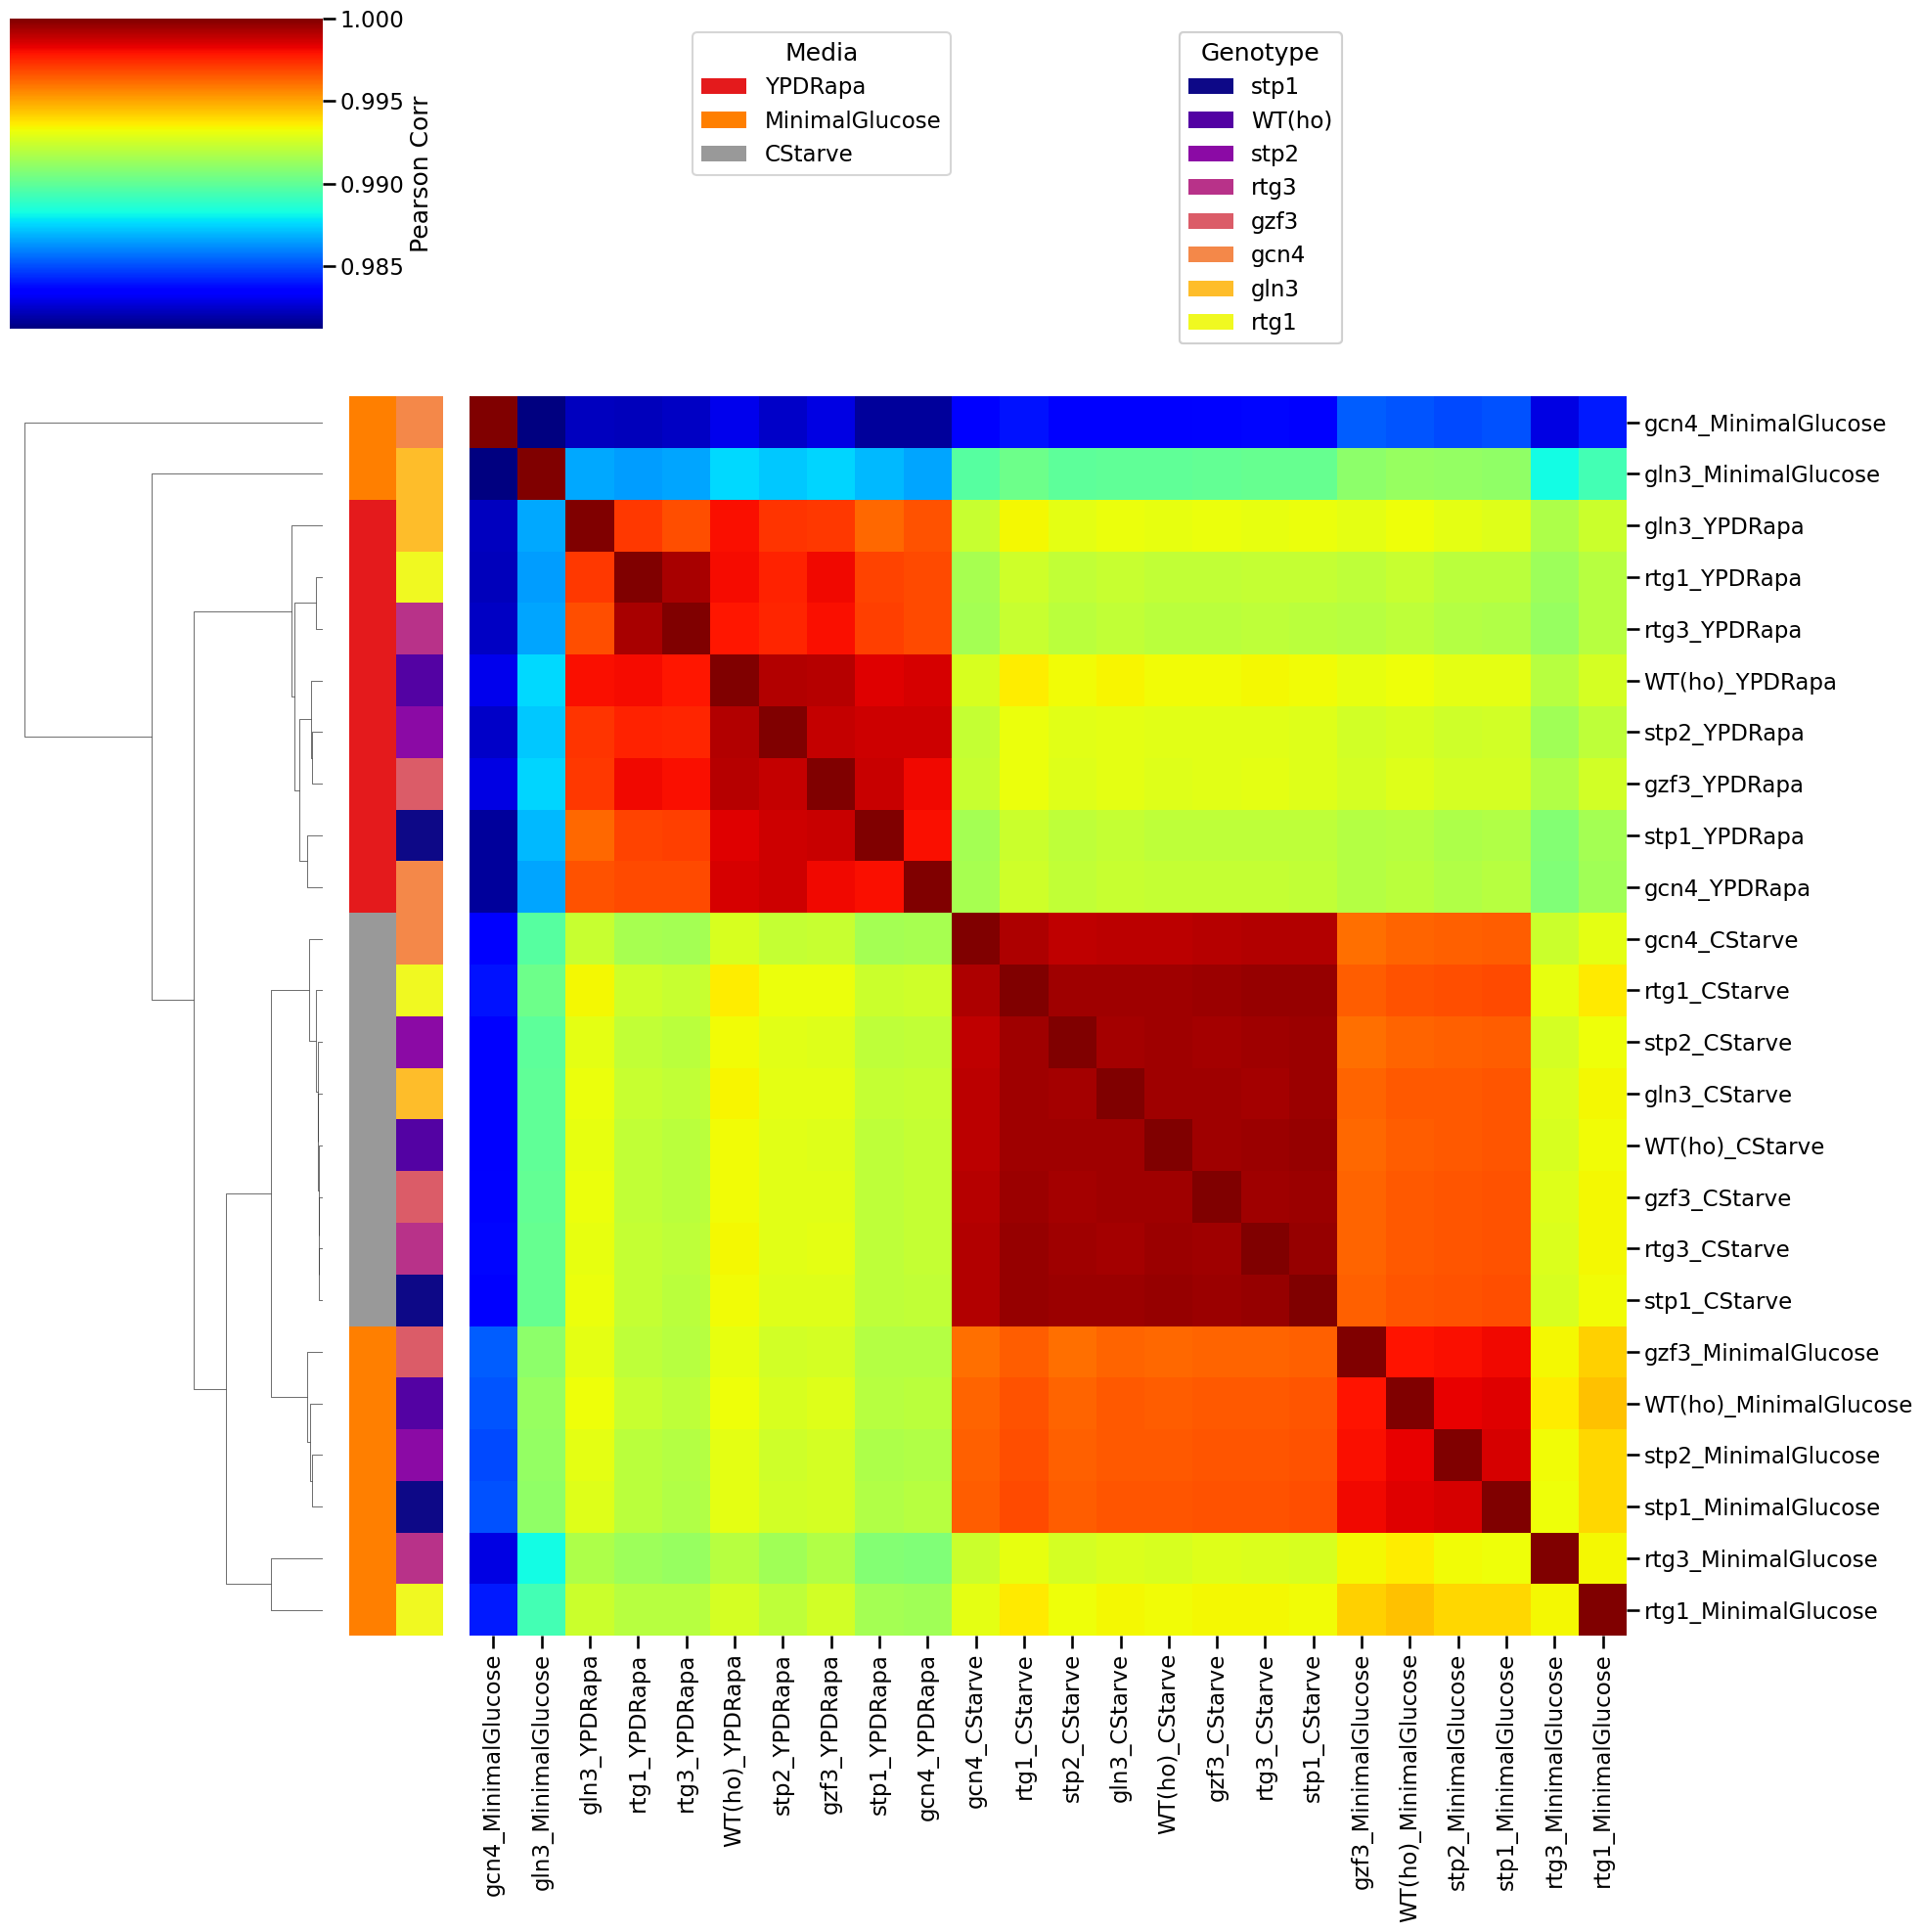

In [83]:
corrs = bonobo_sparse.iloc[:,2:].corr()

details = bonobo_names_df

sns.set_context('talk')

colors = details.medium.unique()
cmap = matplotlib.cm.get_cmap('Set1', len(colors))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
lut = dict(zip(colors, color_list))
row_colors = details.medium.map(lut)

colors2 = details.genotype.unique()
cmap2 = matplotlib.cm.get_cmap('plasma', len(colors2))
color_list2 = [matplotlib.colors.rgb2hex(cmap2(i)[:3]) for i in range(cmap2.N)]
lut2 = dict(zip(colors2, color_list2))
row_colors2 = details.genotype.map(lut2)

# add name to cbar
f1 = sns.clustermap(corrs, row_colors=[row_colors, row_colors2], cmap = 'jet', 
                    figsize=(20,20), cbar_pos=(0.02, 0.80, 0.05, 0.18), cbar_kws= {'label':'Pearson Corr'}, xticklabels=1, yticklabels=1)

f1.ax_col_dendrogram.set_visible(False)
from matplotlib.patches import Patch

handles = [Patch(facecolor=lut[name]) for name in lut]
l1 = plt.legend(handles, lut, title='Media',
           bbox_to_anchor=(.5, .985), bbox_transform=plt.gcf().transFigure, loc='upper right')

# change the location 
handles = [Patch(facecolor=lut2[name]) for name in lut2]
l2 = plt.legend(handles, lut2, title='Genotype',
           bbox_to_anchor=(.7, .985), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Move the legends
plt.gca().add_artist(l1)
plt.gca().add_artist(l2)

plt.tight_layout()
#f1.savefig(results_folder+'/bonobo_correlation_clustermap.pdf', bbox_extra_artists=(l1,l2), #bbox_inches='tight')

## 2.3. Random strategy

Here instead we read the BONOBOs and keep 1000 random edges as representative of the networks.

In [84]:
df_random_1k = get_bonobo_dataframe(nets_fn, strategy = 'random', nk = 1000)

stp1_YPDRapa
1000


In [85]:
df_random_1k

,gene1,gene2,stp1_YPDRapa,WT(ho)_YPDRapa,stp2_MinimalGlucose,rtg3_MinimalGlucose,rtg3_CStarve,gzf3_MinimalGlucose,stp2_YPDRapa,stp2_CStarve,...,gzf3_CStarve,stp1_CStarve,gcn4_MinimalGlucose,gln3_CStarve,rtg1_YPDRapa,gcn4_CStarve,rtg1_CStarve,rtg3_YPDRapa,gln3_YPDRapa,rtg1_MinimalGlucose
16086449,YMR078C,YNL055C,0.354385,0.346420,0.351891,0.351393,0.385971,0.363914,0.358109,0.381561,...,0.387046,0.379315,0.350339,0.392505,0.369263,0.377192,0.388311,0.359134,0.353992,0.365543
17730227,YBR149W,YER044C.A,0.041411,0.055642,0.017601,0.013734,0.016506,0.014454,0.009563,0.018187,...,0.015964,0.017521,0.008527,0.017834,0.006315,0.013358,0.016137,0.005639,0.048521,0.014420
8106606,YOR361C,YGL008C,0.565509,0.572629,0.634957,0.551579,0.653269,0.613316,0.571982,0.653853,...,0.655834,0.652845,0.627103,0.648927,0.580793,0.654552,0.655975,0.581235,0.558105,0.611835
2598178,YDR151C,YMR285C,0.448323,0.447026,0.430557,0.495932,0.473772,0.440437,0.447398,0.471154,...,0.459508,0.456845,0.441712,0.462761,0.444098,0.454744,0.472451,0.443054,0.447721,0.456343
4770851,YDR500C,YLR032W,0.238764,0.236958,0.276273,0.178471,0.280746,0.291619,0.240393,0.263614,...,0.268151,0.253922,0.115724,0.277845,0.220709,0.281028,0.282504,0.238673,0.238422,0.155099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317493,YDL050C,YLR143W,-0.010968,-0.009680,-0.008262,0.014592,0.008971,-0.015540,-0.010819,0.011870,...,0.012285,-0.021768,0.014536,0.007816,-0.001508,0.014262,0.007480,-0.005542,-0.001153,-0.021913
18864063,YNL042W.B,YJL026W,0.205377,0.205639,0.196494,0.184505,0.205463,0.192039,0.204911,0.203765,...,0.203747,0.204765,0.187589,0.204121,0.204013,0.205715,0.205730,0.203404,0.181929,0.199086
5720916,YOL057W,YGR169C.A,0.293679,0.309883,0.373728,0.378519,0.382449,0.364014,0.281221,0.382607,...,0.386907,0.385638,0.466995,0.391085,0.303366,0.387654,0.390351,0.294518,0.318793,0.346251
12475492,YLR253W,YIR013C,-0.034150,-0.036864,-0.041426,-0.026820,-0.016397,-0.049270,-0.033399,-0.020528,...,-0.015830,-0.021513,-0.047166,-0.017217,-0.034454,-0.060823,-0.020696,-0.034090,-0.032497,-0.038271


/tmp/ipykernel_7945/237047313.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Set1', len(colors))
/tmp/ipykernel_7945/237047313.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = matplotlib.cm.get_cmap('plasma', len(colors2))


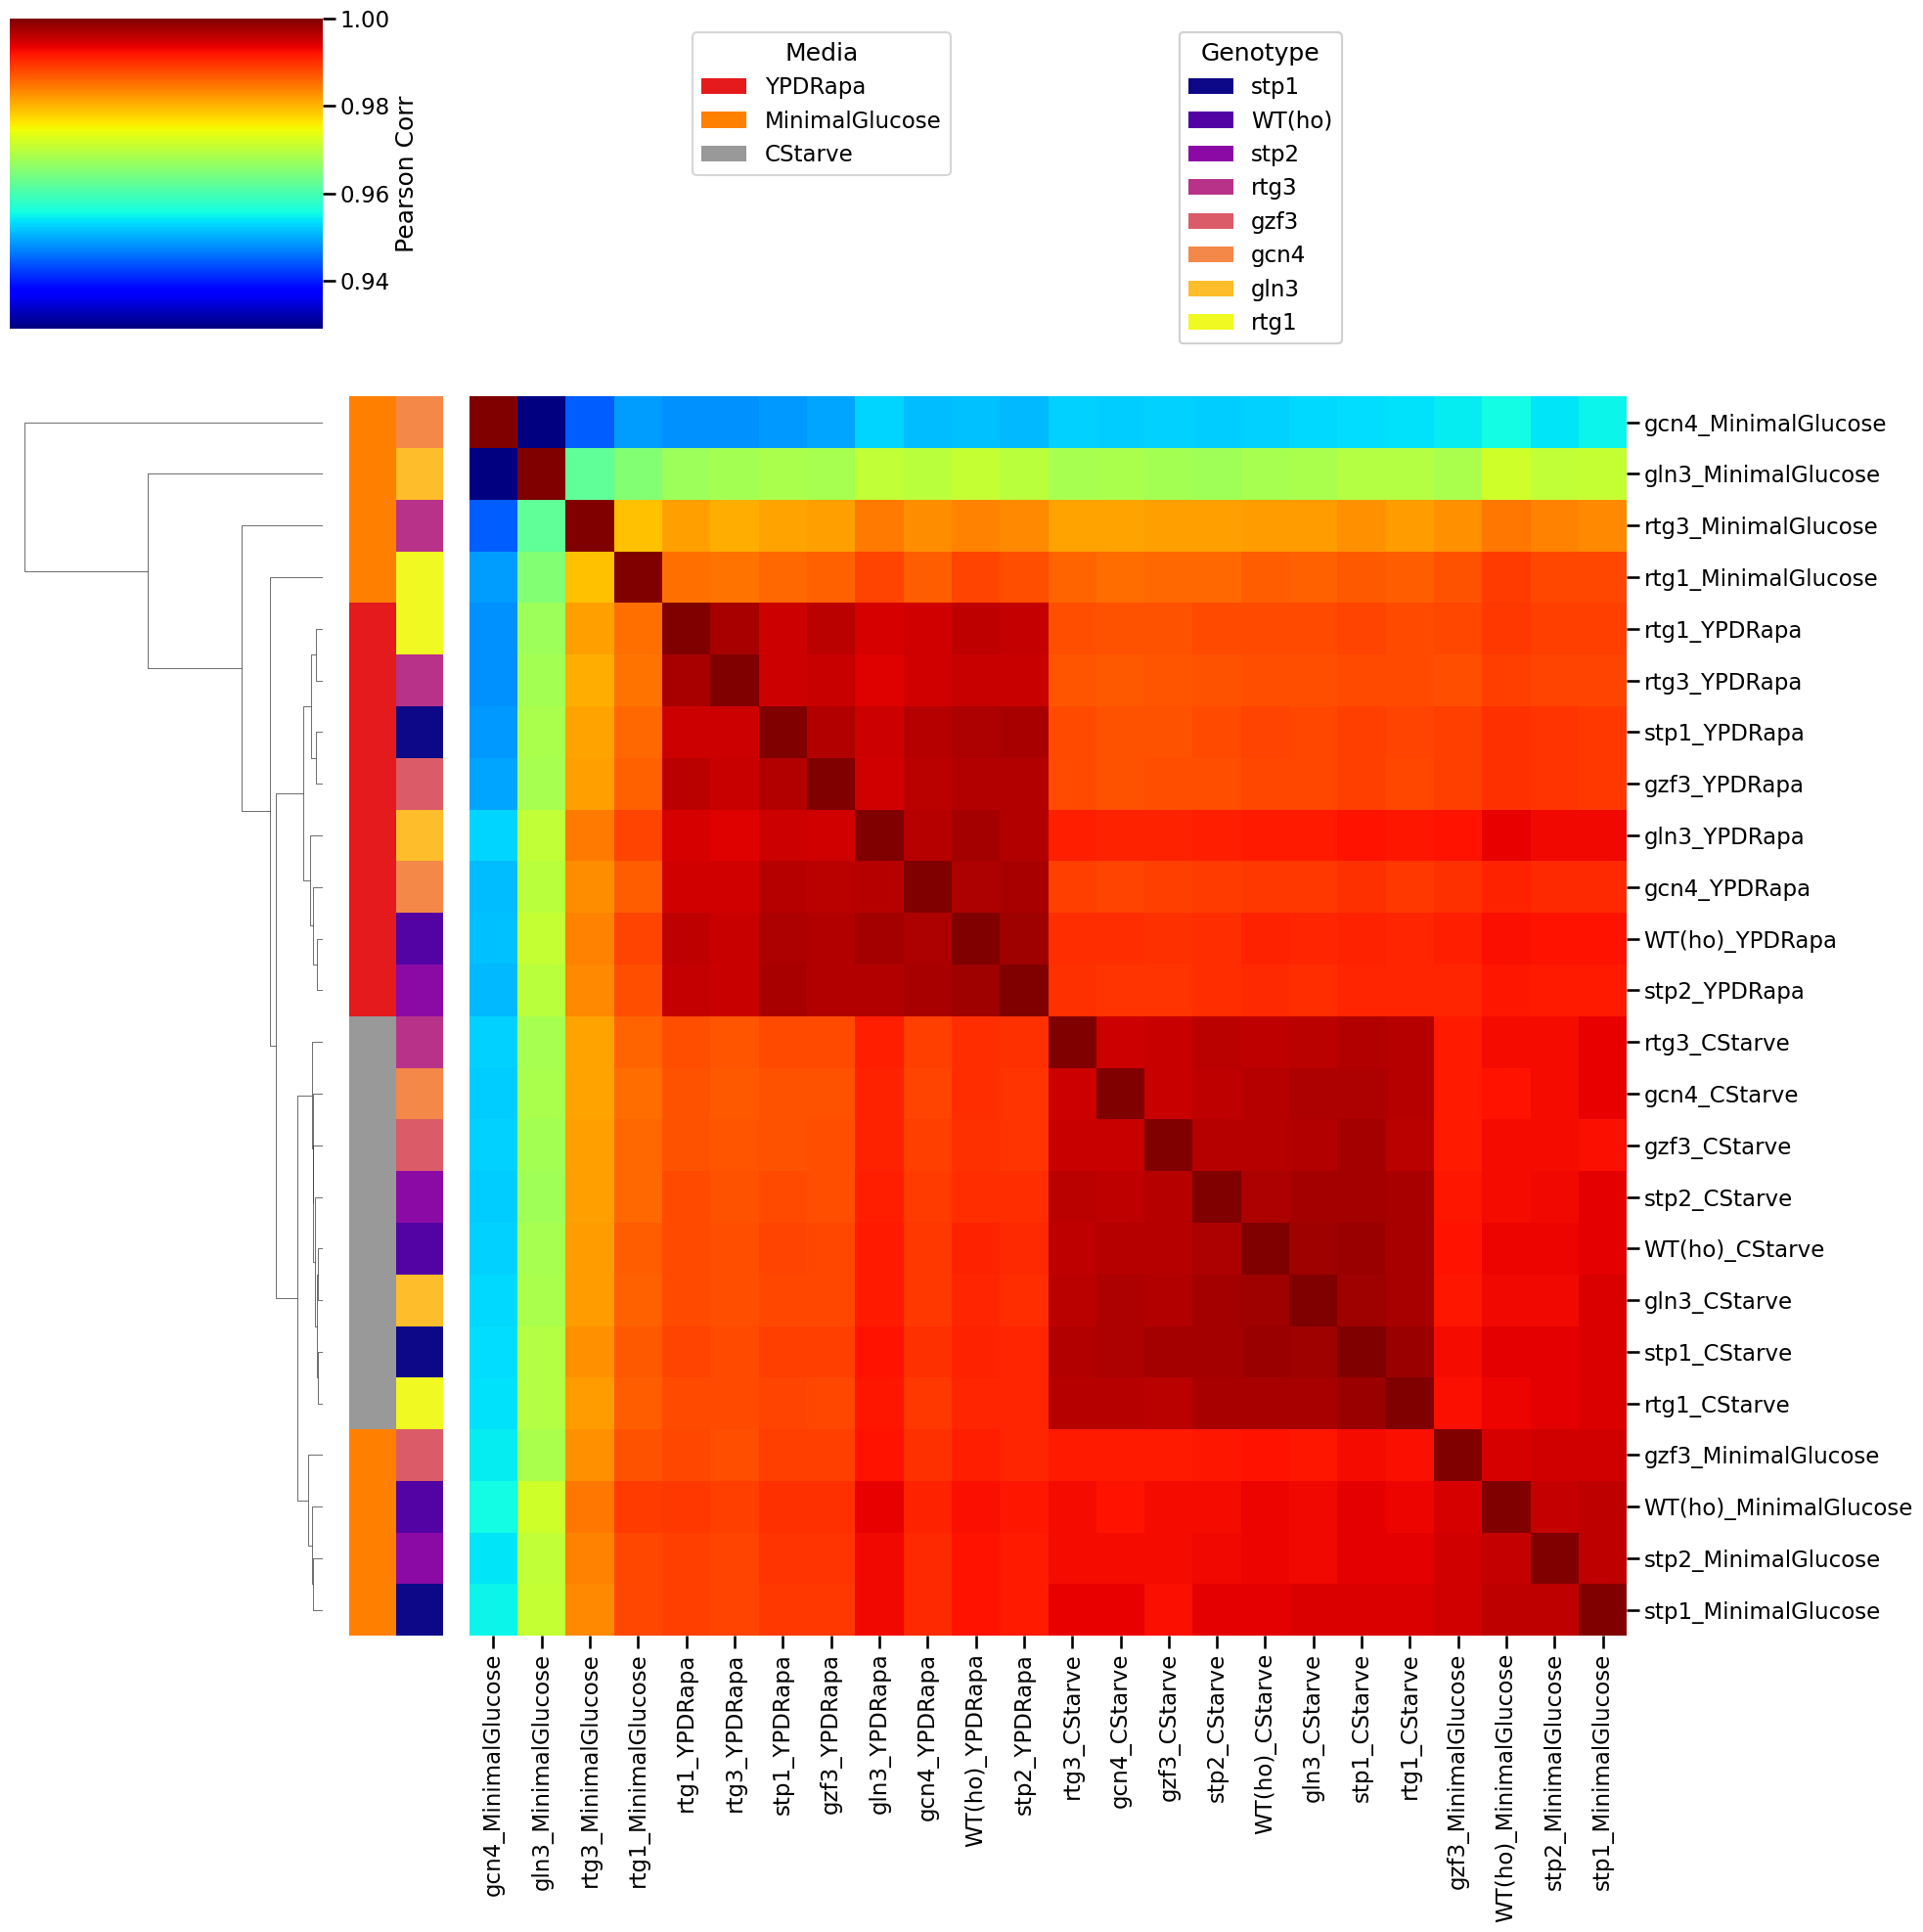

In [86]:
corrs_random = df_random_1k.iloc[:,2:].corr()

details = bonobo_names_df

sns.set_context('talk')

colors = details.medium.unique()
cmap = matplotlib.cm.get_cmap('Set1', len(colors))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
lut = dict(zip(colors, color_list))
row_colors = details.medium.map(lut)

colors2 = details.genotype.unique()
cmap2 = matplotlib.cm.get_cmap('plasma', len(colors2))
color_list2 = [matplotlib.colors.rgb2hex(cmap2(i)[:3]) for i in range(cmap2.N)]
lut2 = dict(zip(colors2, color_list2))
row_colors2 = details.genotype.map(lut2)

# add name to cbar
f1 = sns.clustermap(corrs_random, row_colors=[row_colors, row_colors2], cmap = 'jet', 
                    figsize=(20,20), cbar_pos=(0.02, 0.80, 0.05, 0.18), cbar_kws= {'label':'Pearson Corr'}, xticklabels=1, yticklabels=1)

f1.ax_col_dendrogram.set_visible(False)
from matplotlib.patches import Patch

handles = [Patch(facecolor=lut[name]) for name in lut]
l1 = plt.legend(handles, lut, title='Media',
           bbox_to_anchor=(.5, .985), bbox_transform=plt.gcf().transFigure, loc='upper right')

# change the location 
handles = [Patch(facecolor=lut2[name]) for name in lut2]
l2 = plt.legend(handles, lut2, title='Genotype',
           bbox_to_anchor=(.7, .985), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Move the legends
plt.gca().add_artist(l1)
plt.gca().add_artist(l2)

plt.tight_layout()
#f1.savefig(results_folder+'/bonobo_correlation_clustermap.pdf', bbox_extra_artists=(l1,l2), #bbox_inches='tight')

If you compare these results with those obtained by sparsifying the network it is easy to see that networks tend to be
more similar to each other when using random edges. This makes sense, as the sparsificaytion process will likely pick up
sample-specific trends rather than general, non-significant, edges

## 2.4. Gene startegy

Here, we will get all perturbed edges for the gene GCN4.
Now, for each BONOBO, we select the edges connected to GCN4, to show that the networks are able to detect the effect of
the the KO perturbation. 

We expect the edges connected to GCN4, in the samples where the KO was on GCN4, to exhibit different patterns of
connectivity, as the cells have probably to rewire some of the processes that include GCN4. 

For that we'll use one of the previously defined functions and we ask it to retrieve the edges for 'YEL009C' which is a
synonym for GCN4.


In [133]:
bonobo_gcn4 = get_gene_bonobo_dataframe(nets_fn, gene = 'YEL009C')

Here is the network for the gene YEL009C

In [134]:
bonobo_gcn4.head()

,gene1,gene2,stp1_YPDRapa,WT(ho)_YPDRapa,stp2_MinimalGlucose,rtg3_MinimalGlucose,rtg3_CStarve,gzf3_MinimalGlucose,stp2_YPDRapa,stp2_CStarve,...,gzf3_CStarve,stp1_CStarve,gcn4_MinimalGlucose,gln3_CStarve,rtg1_YPDRapa,gcn4_CStarve,rtg1_CStarve,rtg3_YPDRapa,gln3_YPDRapa,rtg1_MinimalGlucose
YDL248W,YDL248W,YEL009C,0.136910,0.141978,0.141821,0.226556,0.109161,0.128199,0.139813,0.164611,...,0.133148,0.163255,0.176523,0.167549,0.141906,0.179022,0.165228,0.137526,0.158863,0.112152
YDL247W,YDL247W,YEL009C,0.042532,0.042833,0.038861,0.036530,0.045752,0.039668,0.041934,0.045956,...,0.045798,0.045767,0.047290,0.046345,0.040350,0.047344,0.046041,0.075364,0.045128,0.036447
YDL246C,YDL246C,YEL009C,0.020860,0.032956,0.029378,0.027333,0.035763,0.030093,0.032132,0.035973,...,0.035809,0.035777,0.037510,0.036384,0.030702,0.037710,0.036060,0.030251,0.035134,0.027261
YDL245C,YDL245C,YEL009C,0.059314,0.047463,0.057585,0.054063,0.068083,0.058807,0.060115,0.068398,...,0.068153,0.068105,0.070503,0.069003,0.071845,0.070622,0.068529,0.075596,0.067119,0.053938
YDL244W,YDL244W,YEL009C,0.210028,0.214726,0.217188,0.180740,0.170308,0.203080,0.218248,0.203042,...,0.202450,0.179228,0.269001,0.220078,0.219252,0.167111,0.211551,0.224728,0.199473,0.180168


Let's reindex the dataframe, such that we don't need gene1 and gene2 columns.

In [135]:
bonobo_gcn4.index = bonobo_gcn4.gene1 + '-' + bonobo_gcn4.gene2
bonobo_gcn4 = bonobo_gcn4.iloc[:,2:]

We now sort the columns, such that similar phenotypes are close to each other.

In [136]:
bonobo_gcn4 = bonobo_gcn4.sort_index(axis=1)
bonobo_gcn4

,WT(ho)_CStarve,WT(ho)_MinimalGlucose,WT(ho)_YPDRapa,gcn4_CStarve,gcn4_MinimalGlucose,gcn4_YPDRapa,gln3_CStarve,gln3_MinimalGlucose,gln3_YPDRapa,gzf3_CStarve,...,rtg1_YPDRapa,rtg3_CStarve,rtg3_MinimalGlucose,rtg3_YPDRapa,stp1_CStarve,stp1_MinimalGlucose,stp1_YPDRapa,stp2_CStarve,stp2_MinimalGlucose,stp2_YPDRapa
YDL248W-YEL009C,0.164149,0.144194,0.141978,0.179022,0.176523,0.081865,0.167549,0.136149,0.158863,0.133148,...,0.141906,0.109161,0.226556,0.137526,0.163255,0.124734,0.136910,0.164611,0.141821,0.139813
YDL247W-YEL009C,0.045892,0.039505,0.042833,0.047344,0.047290,0.047407,0.046345,0.041192,0.045128,0.045798,...,0.040350,0.045752,0.036530,0.075364,0.045767,0.038987,0.042532,0.045956,0.038861,0.041934
YDL246C-YEL009C,0.035906,0.029948,0.032956,0.037710,0.037510,0.037718,0.036384,0.031458,0.035134,0.035809,...,0.030702,0.035763,0.027333,0.030251,0.035777,0.029489,0.020860,0.035973,0.029378,0.032132
YDL245C-YEL009C,-0.056540,0.058560,0.047463,0.070622,0.070503,0.070705,0.069003,0.061116,0.067119,0.068153,...,0.071845,0.068083,0.054063,0.075596,0.068105,0.057776,0.059314,0.068398,0.057585,0.060115
YDL244W-YEL009C,0.219546,0.201899,0.214726,0.167111,0.269001,0.154417,0.220078,0.205800,0.199473,0.202450,...,0.219252,0.170308,0.180740,0.224728,0.179228,0.198160,0.210028,0.203042,0.217188,0.218248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q0255-YEL009C,0.007611,-0.011963,-0.003616,0.020718,0.017673,0.019927,-0.124414,-0.008015,0.004121,0.007146,...,-0.010046,0.006926,-0.017992,0.006781,-0.049543,-0.013086,-0.004472,0.007933,-0.013354,-0.006106
Q0275-YEL009C,0.206020,0.208240,0.197358,0.206439,0.207626,0.207089,0.138872,0.191948,0.204174,0.152864,...,0.189067,0.205706,0.175386,0.187311,0.180102,0.184287,0.195148,0.206159,0.183839,0.194230
RPM1-YEL009C,0.013360,0.002584,0.007307,0.019979,0.018501,0.019611,0.014633,0.004841,0.011517,0.013116,...,0.003686,0.013000,-0.000948,0.003020,0.013038,0.001934,0.006831,0.013528,0.001778,0.005918
KANMX-YEL009C,0.772503,0.759212,0.753011,0.790131,0.740849,0.788650,0.779111,0.750991,0.764385,0.771662,...,0.749950,0.771868,0.739322,0.742289,0.772455,0.759395,0.755397,0.773302,0.758315,0.751696


In [137]:
# compute variance and absolute average per edge, such that we can select the most variable/strongest edges
variance_peredge = bonobo_gcn4.var(axis = 1)
mean_peredge = np.abs(bonobo_gcn4).mean(axis = 1)

Text(0.5, 1.0, 'Variable edges \n(absolute variance above 90th percentile)')

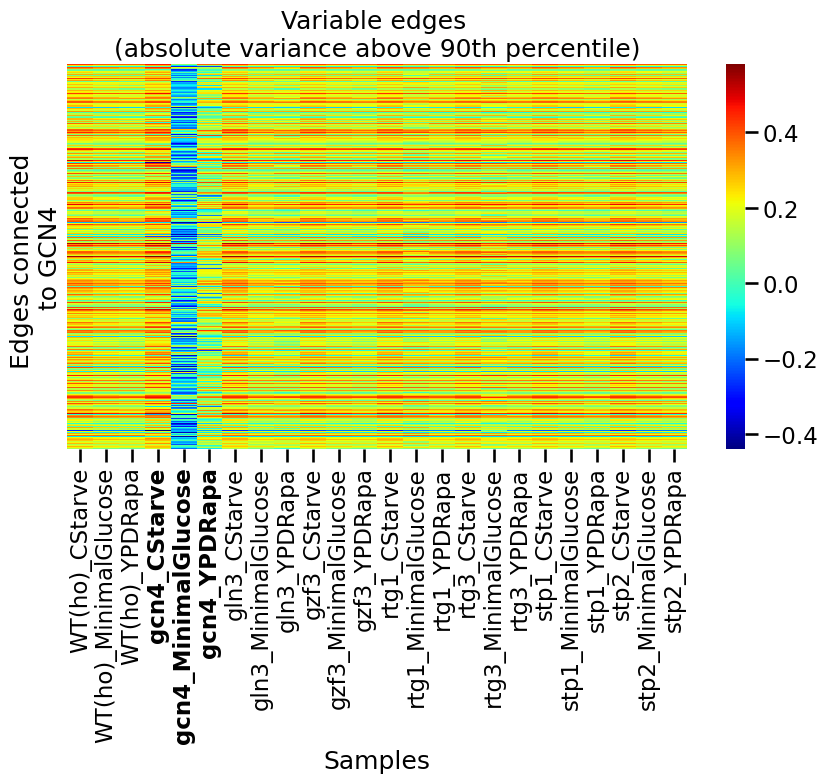

In [138]:
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(bonobo_gcn4[variance_peredge>np.percentile(variance_peredge, 90)], cmap = 'jet', ax = ax, yticklabels=False)

# Get the current xticklabels
xticklabels = ax.get_xticklabels()

# Set the first three xticklabels to bold
for label in xticklabels:
    if label.get_text().startswith('gcn4'):
        label.set_weight('bold')

# Apply the modified labels back to the heatmap
ax.set_xticklabels(xticklabels)


ax.set_ylabel('Edges connected \nto GCN4')
ax.set_xlabel('Samples')
ax.set_title('Variable edges \n(absolute variance above 90th percentile)')

Text(0.5, 1.0, 'Strongest edges \n(absolute mean above 90th percentile)')

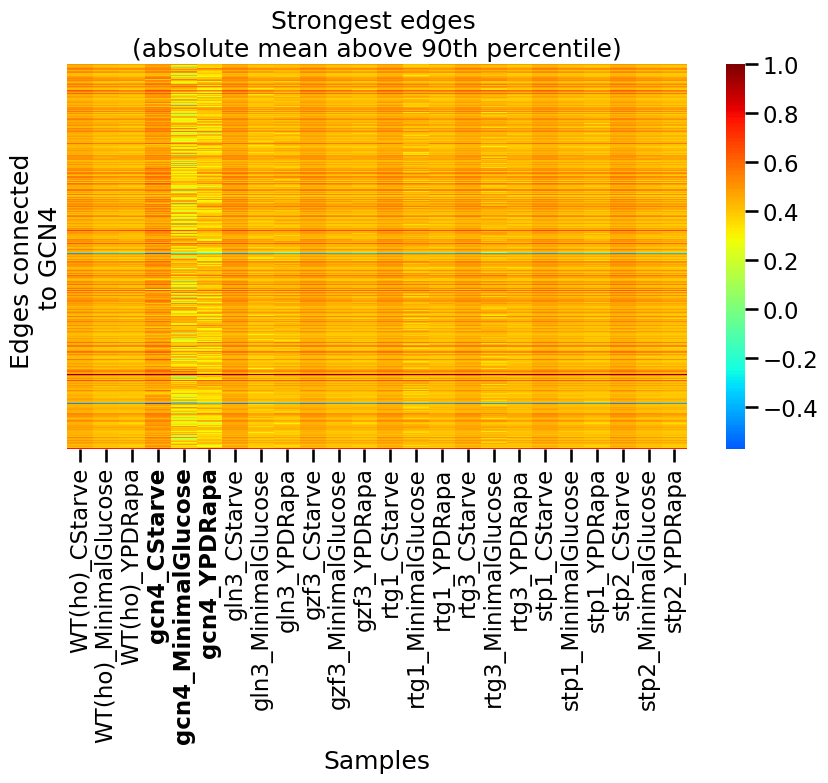

In [140]:
# Now for the strongest edges
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(bonobo_gcn4[mean_peredge>np.percentile(mean_peredge, 90)], cmap = 'jet', ax = ax, yticklabels=False, center = 0)


# Get the current xticklabels
xticklabels = ax.get_xticklabels()

# Set the first three xticklabels to bold
for label in xticklabels:
    if label.get_text().startswith('gcn4'):
        label.set_weight('bold')

# Apply the modified labels back to the heatmap
ax.set_xticklabels(xticklabels)

ax.set_ylabel('Edges connected \nto GCN4')
ax.set_xlabel('Samples')
ax.set_title('Strongest edges \n(absolute mean above 90th percentile)')

In both cases, you can see that the gcn4 KO samples (x-axis labels in bold) have different co-expression values compared to the rest of the networks. 

# References

1- Saha, Enakshi, et al. "Bayesian Optimized sample-specific Networks Obtained By Omics data (BONOBO)." bioRxiv (2023).

2- Jackson, Christopher A., et al. "Gene regulatory network reconstruction using single-cell RNA sequencing of barcoded genotypes in diverse environments." elife 9 (2020): e51254.

3- Ben Guebila, Marouen, et al. "The Network Zoo: a multilingual package for the inference and analysis of gene regulatory networks." Genome Biology 24.1 (2023): 45.